In [33]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datasets import Dataset, DatasetDict

In [5]:
path = Path.home()/'us-patent'

In [6]:
path

PosixPath('/root/us-patent')

In [7]:
!ls {path}

sample_submission.csv  train.csv
test.csv	       us-patent-phrase-to-phrase-matching.zip


In [8]:
df = pd.read_csv(path/'train.csv')

In [9]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [10]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [11]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [12]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [13]:
ds = Dataset.from_pandas(df)

In [14]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [15]:
model_nm = 'microsoft/deberta-v3-small'

In [16]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)

tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
tokz.tokenize('tira giu un bel porcone')

['▁t', 'ira', '▁giu', '▁un', '▁be', 'l', '▁por', 'cone']

In [18]:
def tok_func(x): return tokz(x["input"])

In [19]:
tok_ds = ds.map(tok_func, batched=True)

Parameter 'function'=<function tok_func at 0x7f086e771820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/37 [00:00<?, ?ba/s]

In [21]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [22]:
tokz.vocab['▁of']

265

In [23]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [24]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [25]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [26]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [30]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [31]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [32]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906005

In [34]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

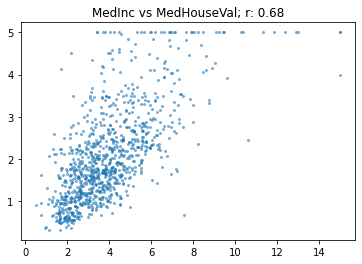

In [35]:
show_corr(housing, 'MedInc', 'MedHouseVal')

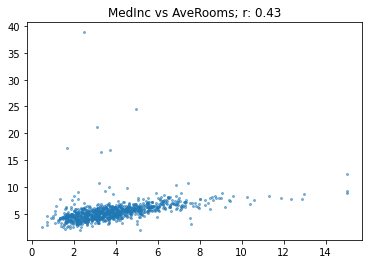

In [36]:
show_corr(housing, 'MedInc', 'AveRooms')

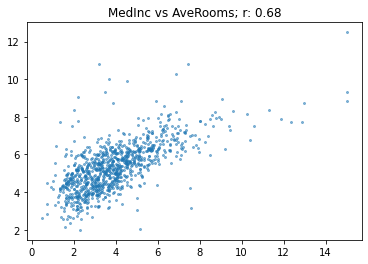

In [37]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

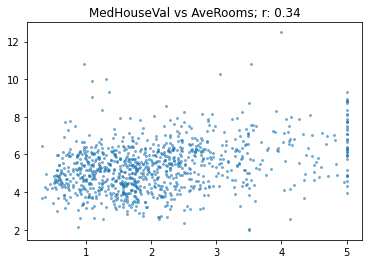

In [38]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

In [39]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [40]:
from transformers import TrainingArguments,Trainer

In [41]:
bs = 128
epochs = 4

In [42]:
lr = 8e-05

In [43]:
args = TrainingArguments(
    'outputs', 
    learning_rate=lr, 
    warmup_ratio=0.1, 
    lr_scheduler_type='cosine', 
    fp16=True,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=bs, 
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, 
    weight_decay=0.01, 
    report_to='none'
)

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

trainer = Trainer(
    model, 
    args, 
    train_dataset=dds['train'], 
    eval_dataset=dds['test'],
    tokenizer=tokz, 
    compute_metrics=corr_d
)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [45]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, context, id, input, anchor. If target, context, id, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.023849,0.798557
2,No log,0.023218,0.826439
3,0.030900,0.021937,0.834503
4,0.030900,0.021931,0.834502


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, context, id, input, anchor. If target, context, id, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, context, id, input, anchor. If target, context, id, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved 

In [46]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: target, context, id, input, anchor. If target, context, id, input, anchor are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


array([[ 0.44],
       [ 0.65],
       [ 0.61],
       [ 0.33],
       [-0.03],
       [ 0.54],
       [ 0.51],
       [ 0.01],
       [ 0.34],
       [ 1.09],
       [ 0.24],
       [ 0.23],
       [ 0.76],
       [ 0.82],
       [ 0.72],
       [ 0.43],
       [ 0.3 ],
       [-0.01],
       [ 0.66],
       [ 0.38],
       [ 0.4 ],
       [ 0.26],
       [ 0.2 ],
       [ 0.24],
       [ 0.59],
       [-0.01],
       [-0.06],
       [-0.04],
       [-0.03],
       [ 0.6 ],
       [ 0.33],
       [ 0.02],
       [ 0.72],
       [ 0.51],
       [ 0.44],
       [ 0.2 ]])

In [47]:
preds = np.clip(preds, 0, 1)
preds

array([[0.44],
       [0.65],
       [0.61],
       [0.33],
       [0.  ],
       [0.54],
       [0.51],
       [0.01],
       [0.34],
       [1.  ],
       [0.24],
       [0.23],
       [0.76],
       [0.82],
       [0.72],
       [0.43],
       [0.3 ],
       [0.  ],
       [0.66],
       [0.38],
       [0.4 ],
       [0.26],
       [0.2 ],
       [0.24],
       [0.59],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.6 ],
       [0.33],
       [0.02],
       [0.72],
       [0.51],
       [0.44],
       [0.2 ]])

In [48]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})
submission

Dataset({
    features: ['id', 'score'],
    num_rows: 36
})

In [49]:
submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

854